In [1]:
import pandas as pd
import numpy as np
from itertools import product

from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model

from utils import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('vodafone_data.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Volume
0,2016-02-11,29.330000,29.510000,29.030001,29.270000,4805000
1,2016-02-12,29.520000,29.950001,29.410000,29.900000,3116500
2,2016-02-16,29.950001,30.420000,29.900000,30.260000,4037900
3,2016-02-17,31.000000,31.320000,30.900000,31.090000,4313800
4,2016-02-18,31.090000,31.150000,30.920000,30.959999,3522800


## Підготовка даних

In [4]:
def dataset_preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date_index'] = pd.DatetimeIndex(df['Date']) 
    
    data_no_missing = df.copy(deep=True)

    data_no_missing = data_no_missing.set_index('Date_index').asfreq('D')

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        data_no_missing[col] = data_no_missing[col].interpolate()

    data_no_missing = data_no_missing.reset_index(drop=False)

    data_no_missing['Date'] = pd.to_datetime(data_no_missing['Date_index']).dt.date
    data_no_missing['year'] = pd.to_datetime(data_no_missing['Date']).dt.year
    data_no_missing['quarter'] = pd.to_datetime(data_no_missing['Date']).dt.quarter
    data_no_missing['month'] = pd.to_datetime(data_no_missing['Date']).dt.month
    
    return df, data_no_missing

In [5]:
df, data_no_missing = dataset_preprocess(data)

### Перевірка на стаціонарність

#### Тест Дікі-Фулера

In [6]:
stationarity_test(data_no_missing.Close, smt.adfuller)

{'adfuller_statistics': -1.2810249204236712,
 'adfuller_p_value': 0.6378081111339106,
 'adfuller_critical_values': {'1%': -3.4339382310452033,
  '5%': -2.863125003847544,
  '10%': -2.56761380228936}}

#### KPSS тест

In [7]:
stationarity_test(data_no_missing.Close, smt.kpss)

{'kpss_statistics': 5.98948825089506,
 'kpss_p_value': 0.01,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Бачимо, що вихідний часовий ряд не є стаціонарним

## Побудова моделей за допомогою крос-валідації для різних наборів порядків

In [8]:
data_no_missing = data_no_missing.reset_index(drop=False)

In [9]:
data_no_missing.head(2)

,index,Date_index,Date,Open,High,Low,Close,Volume,year,quarter,month
0,0,2016-02-11,2016-02-11,29.33,29.510000,29.030001,29.27,4805000.0,2016,1,2
1,1,2016-02-12,2016-02-12,29.52,29.950001,29.410000,29.90,3116500.0,2016,1,2


In [10]:
ORDERS_RANGE = range(1, 6)

In [11]:
N_SPLITS = 7

In [12]:
INDEX = pd.MultiIndex.from_product((ORDERS_RANGE, ORDERS_RANGE, list(range(N_SPLITS))))

In [26]:
def get_observed_metrics(df, predictions, arch, metrics_list=METRICS, titles_list=METRICS_TITLES):
    
    metrics_df = pd.DataFrame()
    
    for metric, title in zip(metrics_list, titles_list):
        calculated_metric = metric(df, predictions)
        metrics_df.loc[0, title] = calculated_metric
    
    metrics_df['AIC'] = aic(df.shape[0], mean_squared_error(df, predictions),
                                         arch.num_params
                                        )

    metrics_df['BIC'] = bic(df.shape[0], mean_squared_error(df, predictions),
                                         arch.num_params
                                        )
    
    return metrics_df

In [36]:
def make_cross_validation(df, target_column='Close', n_splits=5, test_size=30, p=1, q=1, vol='ARCH',
                          lags=12, folds_plots_size=(10, 30), stat_plot_size=(10, 8), plot=False
                          ):
    ts = df[target_column]

    folds_indexes = list(TimeSeriesSplit(n_splits=n_splits, test_size=test_size).split(ts))
    min_fold_len = min([len(fold[0]) for fold in folds_indexes])

    for i in range(len(folds_indexes)):
        folds_indexes[i] = (folds_indexes[i][0][-min_fold_len:], folds_indexes[i][1])

    if plot:
        plot_data_by_fold(df, folds_indexes, folds_plots_size)

    all_metrics_df_test_arch = pd.DataFrame()

    for fold_index, fold in enumerate(folds_indexes):
        train_indexes = fold[0]
        test_indexes = fold[1]

        train_df_tmp = df.loc[train_indexes, :]
        test_df_tmp = df.loc[test_indexes, :]
        
        df_stationary, data_diffed, data_logged = to_stationary(train_df_tmp)
        df_stationary_test, data_diffed_test, data_logged_test = to_stationary(test_df_tmp)
        
        try:
            arch = arch_model(np.power(df_stationary, 2), mean='Zero', vol=vol, p=p, q=q)
            arch_fitted = arch.fit()

            preds = pd.Series(arch_fitted.forecast(horizon=df_stationary_test.shape[0]).variance.values[-1], copy=True)
            y_true = pd.Series(np.array([np.power(df_stationary_test, 2).std() ** 2] * df_stationary_test.shape[0]))
        
            metrics_df_test_arch = get_observed_metrics(y_true, preds, arch_fitted)
        except ValueError:
            metrics_df_test_arch = pd.DataFrame()
        
        if not metrics_df_test_arch.empty:
            metrics_df_test_arch.index = pd.Series(str((p, q, vol, fold_index)))

        all_metrics_df_test_arch = pd.concat((all_metrics_df_test_arch, metrics_df_test_arch), axis=0)

    return all_metrics_df_test_arch

In [40]:
def get_cross_val_results(data, n_splits, test_size, lags, orders_range=ORDERS_RANGE, 
                          models_list=['ARCH', 'GARCH', 'EGARCH', 'FIARCH'],
                          plot=False):
    
    all_metrics_df_test = pd.DataFrame()
    
    for vol in ['ARCH', 'GARCH', 'EGARCH', 'FIARCH']:
        for p, q in product(ORDERS_RANGE, ORDERS_RANGE):
            test_metrics_df_arch = make_cross_validation(data, p=p, q=q, vol=vol)
            all_metrics_df_test = pd.concat((all_metrics_df_test, test_metrics_df_arch))
    
    return all_metrics_df_test

In [41]:
all_metrics_df_test_arch_models = get_cross_val_results(data_no_missing, N_SPLITS, 100, 30)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -7178.91301690086
Iteration:      2,   Func. Count:      9,   Neg. LLF: -8873.305738864805
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8873.305737758796
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8875.573460294092
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8875.573459051164
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8870.367426866673
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8870.367425659511
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      3,   Neg. LLF: -8865.695747883714
Optimization te

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -8890.805884726919
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8890.805885523368
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8894.27948551339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,   Func. Count:     16,   Neg. LLF: -8897.10793772167
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8897.107938397528
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -8886.5101803021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.510181089583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8890.805884726919
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8890.805885523368
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8894.279484743125
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8894.27948551339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -7178.654395816526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 273753932.1825301
Iteration:      3,

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -7176.99803451129
Iteration:      2,   Func. Count:     11,   Neg. LLF: -8886.735335484253
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.73533625405
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      4,   Neg. LLF: -8886.5101803021
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8886.510181089583
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.445007225244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9511.445004091649
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization term

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -9501.810002449984
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9501.809999330835
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.445007225244
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9511.445004091649
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9521.15535951963
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: -9521.155362698742
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9521.15535951963
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7169.318065200581
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64579962.57030247
Iteration:      3,   Func. Count:     20,   Neg. LLF: -9541.40583545758
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9541.405833474797
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: -7167.846156807691
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64538655.09088434
Iteration:      3,   Func. Count:     21,   Neg. LLF: -7167.846156807691
Iteration:      4,   Func. Count:     29,   Neg. LLF: -9529.758606858255
Optimi

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514.99166113927
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.88672330669
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.886723875916
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.43929065697
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.43929116946
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9521.838665289273
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.83866578571
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9514.991660665106
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9514

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.914107868237
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.914108393932
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9502.88672330669
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9502.886723875916
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9495.119162684721
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.119163363563
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      7,   Neg. LLF: -9495.119162684721
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.119163363563
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9538.478853231289
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7162.446206223677
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9498.336390302084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9498.336390980021
            Iterations: 6
            

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp 

Iteration:      1,   Func. Count:      7,   Neg. LLF: -9495.119162684721
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9495.119163363563
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7179.7498342583585
Iteration:      2,   Func. Count:     19,   Neg. LLF: 276885706.9333621
Iteration:      3,   Func. Count:     26,   Neg. LLF: -9538.478852586959
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9538.478853231289
            Iterations: 7
            Function evaluations: 26
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      8,   Neg. LLF: -7162.446206223677
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9498.336390302084
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9498.336390980021
            Iterations: 6
            

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  w

Iteration:      1,   Func. Count:      4,   Neg. LLF: -9546.829441509355
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9546.829434179605
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: -9571.270522254159
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9571.270514681411
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9551.78881806691
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9551.788807946294
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9560.981611841333
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2619.099990175403
Iteration:      2,   Func. Count:     16,   Neg. LLF: -9587.211262791005
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9587.211256216448
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9578.166878801145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9578.166868692708
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9560.061269287111
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.061259179334
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9606.488777612372
Inequality constr

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: -9619.935145464451
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9619.93514547834
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9595.253977491611
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9595.25397871953
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9603.14778114287
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9603.147782891594
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9595.969104409178
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -959

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      5,   Neg. LLF: -9511.045951308097
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9511.045940499782
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9493.98460528143
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9493.984594377627
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -9520.06750246673
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9520.06749143
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9512.16699746307
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.16

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      3,   Func. Count:     25,   Neg. LLF: -9549.204892696143
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9549.204890295638
            Iterations: 4
            Function evaluations: 25
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9534.075912462868
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.07590113853
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9542.745361127145
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9542.745350350498
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9541.175130346019
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9555.744415978214
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9555.744409734294
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9537.44009506523
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9537.440088764299
            Iterations: 5
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9586.142929204027
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9586.142927781613
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9552.949318214114
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      9,   Neg. LLF: -9590.998047420653
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9590.998051405897
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9461.00528763304
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9461.005273616021
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9470.906966350925
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9470.906952925676
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -9469.641698951778
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: -9483.677630562746
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.677613807413
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9482.744917076157
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9482.744899907637
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9464.82096458039
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9464.820947395001
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9506.488406343702
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      9,   Neg. LLF: 2602.7582286321294
Iteration:      2,   Func. Count:     18,   Neg. LLF: -9553.82293124875
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9553.822933114274
            Iterations: 2
            Function evaluations: 18
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9521.766724053534
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9521.766715510987
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9529.810692904817
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9529.810684962282
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9529.566023256335
Optimization term

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: -9535.017721433727
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9535.01771878764
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: 2732.723339387845
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9536.919142512383
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9536.91914455347
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: 2745.6480446793958
Iteration:      2,   Func. Count:     23,   Neg. LLF: -9518.987117672255
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9518.987119574267
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
Iteration:      1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: -9444.344057840935
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9444.344042535682
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9426.940042293949
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9426.940026914068
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: -9457.144357844409
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9457.144342808053
            Iterations: 1
            Function evaluations: 7
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: -9457.76080454536
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9490.588179184044
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9490.588163205113
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 2619.3706667284914
Iteration:      2,   Func. Count:     24,   Neg. LLF: 2585.734998720475
Iteration:      3,   Func. Count:     35,   Neg. LLF: -9503.3295402538
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9503.329540890702
            Iterations: 3
            Function evaluations: 35
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9500.224808707877
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9500.224793513418
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: -9512.150367550268
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9512.150358321353
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9519.778853370384
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9519.778844745502
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9520.17109589979
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9520.171086835018
            Iterations: 5
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9501.915820811677
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: 2734.820912610781
Iteration:      2,   Func. Count:     26,   Neg. LLF: 2734.820912610781
Iteration:      3,   Func. Count:     40,   Neg. LLF: -9533.31172541264
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9533.31172800526
            Iterations: 3
            Function evaluations: 40
            Gradient evaluations: 3
Iteration:      1,   Func. Count:     12,   Neg. LLF: 2747.642837667181
Iteration:      2,   Func. Count:     25,   Neg. LLF: -9515.395265374988
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9515.395267504893
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9560.891169046308
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9560.891170552364
            Iterations: 1
            Functio

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: -9437.086206261134
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.086190265225
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9437.964614174665
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9437.964592890716
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9446.030432944952
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9446.030412205517
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: -9446.602536138726
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: -9482.346349857291
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9482.346333343265
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9483.234526516142
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9483.234509647664
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9464.612393056175
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9464.612376122852
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: -9511.480216023303
Inequality constraints incompatible    (Exit mode 4)
            Current function value

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     11,   Neg. LLF: -9486.612129581252
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9486.612119377201
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     11,   Neg. LLF: -9534.55821302066
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9534.558207693048
            Iterations: 1
            Function evaluations: 11
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9507.789537311239
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -9507.789532407962
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     12,   Neg. LLF: -9514.46116421227
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      5,   Neg. LLF: 672103807.7087629
Iteration:      2,   Func. Count:     19,   Neg. LLF: 672103805.2781537
Iteration:      3,   Func. Count:     23,   Neg. LLF: 671943035.6820557
Optimization terminated successfully    (Exit mode 0)
            Current function value: 671943035.6820557
            Iterations: 3
            Function evaluations: 23
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      4,   Neg. LLF: 2631230.0658065453
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2631223.5174876
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      4,   Neg. LLF: 2424615.1151462793
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2424613.1178963752
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   F

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      7,   Neg. LLF: 686934507.0559042
Iteration:      2,   Func. Count:     23,   Neg. LLF: 686934504.1640803
Iteration:      3,   Func. Count:     29,   Neg. LLF: 686755989.7779806
Iteration:      4,   Func. Count:     35,   Neg. LLF: 687017655.4687796
Iteration:      5,   Func. Count:     42,   Neg. LLF: 686755988.588413
Iteration:      6,   Func. Count:     48,   Neg. LLF: 687017559.8045442
Iteration:      7,   Func. Count:     54,   Neg. LLF: 686755971.6242747
Optimization terminated successfully    (Exit mode 0)
            Current function value: 686755971.6242747
            Iterations: 7
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      7,   Neg. LLF: 679174297.6556756
Iteration:      2,   Func. Count:     23,   Neg. LLF: 678976574.3677605
Iteration:      3,   Func. Count:     29,   Neg. LLF: 678976571.0467975
Iteration:      4,   Func. Count:     34,   Neg. LLF: 678976571.0467975
Op

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      9,   Neg. LLF: 679174297.6556756
Iteration:      2,   Func. Count:     27,   Neg. LLF: 695653414.6040263
Iteration:      3,   Func. Count:     36,   Neg. LLF: 694658741.4370595
Iteration:      4,   Func. Count:     45,   Neg. LLF: 695653416.6390402
Iteration:      5,   Func. Count:     55,   Neg. LLF: nan
Iteration:      6,   Func. Count:     66,   Neg. LLF: 1756449052.0599885
Iteration:      7,   Func. Count:     78,   Neg. LLF: nan
Iteration:      8,   Func. Count:     90,   Neg. LLF: nan
Iteration:      9,   Func. Count:    101,   Neg. LLF: nan
Iteration:     10,   Func. Count:    119,   Neg. LLF: nan
Iteration:     11,   Func. Count:    137,   Neg. LLF: nan
Iteration:     12,   Func. Count:    155,   Neg. LLF: nan
Iteration:     13,   Func. Count:    173,   Neg. LLF: 1790579910.1807253
Iteration:     14,   Func. Count:    191,   Neg. LLF: 1790579910.1807253
Iteration:     15,   Func. Count:    209,   Neg. LLF: 1790579910.1807253
Iteration:    

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      2,   Func. Count:     23,   Neg. LLF: 1207026449.7831268
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1206433495.9228895
Iteration:      4,   Func. Count:     37,   Neg. LLF: 1206433495.9092426
Iteration:      5,   Func. Count:     43,   Neg. LLF: 1206433495.8111498
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1206669988.2610874
Iteration:      7,   Func. Count:     56,   Neg. LLF: 1206669987.6484778
Iteration:      8,   Func. Count:     63,   Neg. LLF: 1207026449.7831116
Iteration:      9,   Func. Count:     73,   Neg. LLF: 1206433486.5456991
Iteration:     10,   Func. Count:     79,   Neg. LLF: 1206433486.5273578
Iteration:     11,   Func. Count:     85,   Neg. LLF: 1206433486.5268018
Iteration:     12,   Func. Count:     91,   Neg. LLF: 1206433486.5267978
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1206433486.5267935
            Iterations: 13
            Function evaluations: 92
            Gradient eva

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      8,   Neg. LLF: 951883.6391146865
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 951883.0837322171
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 919306.4822361213
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 919305.9478085681
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 918152.5655148049
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 918152.0356886259
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      8,   Neg. LLF: 938198.8022039707
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 938198.2

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2018841.0204154644
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2018836.5868454052
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2030550.0207795962
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2030547.7153006839
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 100577919.77655
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 101233181.05635664
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      7,   Neg. LLF: 1490777.5552080343
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1490

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      2,   Func. Count:     27,   Neg. LLF: 370820506.81234515
Iteration:      3,   Func. Count:     39,   Neg. LLF: 370823107.5243437
Iteration:      4,   Func. Count:     51,   Neg. LLF: 370823098.463215
Iteration:      5,   Func. Count:     63,   Neg. LLF: 387574906.0675539
Iteration:      6,   Func. Count:     73,   Neg. LLF: 387574906.06976366
Iteration:      7,   Func. Count:     83,   Neg. LLF: 355585025.6013526
Iteration:      8,   Func. Count:     93,   Neg. LLF: 355585007.8610827
Iteration:      9,   Func. Count:    103,   Neg. LLF: 342229009.2789393
Iteration:     10,   Func. Count:    113,   Neg. LLF: 343566131.96306515
Iteration:     11,   Func. Count:    122,   Neg. LLF: 343566146.3835023
Iteration:     12,   Func. Count:    131,   Neg. LLF: 355585025.96832705
Iteration:     13,   Func. Count:    141,   Neg. LLF: 355585025.9907276
Iteration:     14,   Func. Count:    152,   Neg. LLF: 355585025.99051034
Iteration:     15,   Func. Count:    163,   Neg. LLF: 355585

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:      9,   Neg. LLF: 958434.2027097864
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 958433.6650348287
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 945570.0740658361
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 945569.5502202044
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 355110336.2693587
Iteration:      2,   Func. Count:     29,   Neg. LLF: 355110335.57151747
Iteration:      3,   Func. Count:     38,   Neg. LLF: 355099854.41737545
Iteration:      4,   Func. Count:     47,   Neg. LLF: 387267304.7473607
Iteration:      5,   Func. Count:     57,   Neg. LLF: 342941172.9945874
Iteration:      6,   Func. Count:     66,   Neg. LLF: 355585046.83465654
Iteration: 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

1
Iteration:      1,   Func. Count:      9,   Neg. LLF: 1081693.354682822
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1081692.7344211214
            Iterations: 1
            Function evaluations: 9
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 226740305.30539525
Iteration:      2,   Func. Count:     29,   Neg. LLF: 258664858.60436198
Iteration:      3,   Func. Count:     39,   Neg. LLF: 258664858.60436198
Iteration:      4,   Func. Count:     49,   Neg. LLF: 258664858.60436195
Iteration:      5,   Func. Count:     59,   Neg. LLF: 258664858.60436046
Iteration:      6,   Func. Count:     69,   Neg. LLF: 263237510.66270655
Iteration:      7,   Func. Count:     80,   Neg. LLF: 259322821.5418312
Iteration:      8,   Func. Count:     91,   Neg. LLF: 603049058.8909302
Iteration:      9,   Func. Count:    103,   Neg. LLF: 603916885.4177312
Iteration:     10,   Func. Count:    116,   Neg. LLF: 603916885.41

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     18,   Func. Count:    221,   Neg. LLF: 265795407.51191816
Iteration:     19,   Func. Count:    233,   Neg. LLF: 266385492.56825316
Iteration:     20,   Func. Count:    244,   Neg. LLF: 260817667.68308794
Iteration:     21,   Func. Count:    256,   Neg. LLF: 242461402.2564799
Iteration:     22,   Func. Count:    268,   Neg. LLF: 242461402.25221527
Iteration:     23,   Func. Count:    280,   Neg. LLF: 242461402.23110753
Iteration:     24,   Func. Count:    292,   Neg. LLF: nan
Iteration:     25,   Func. Count:    305,   Neg. LLF: nan
Iteration:     26,   Func. Count:    319,   Neg. LLF: 246428498.169974
Iteration:     27,   Func. Count:    333,   Neg. LLF: nan
Iteration:     28,   Func. Count:    347,   Neg. LLF: nan
Iteration:     29,   Func. Count:    359,   Neg. LLF: 2132423530.836226
Iteration:     30,   Func. Count:    370,   Neg. LLF: 2132658829.8515563
Iteration:     31,   Func. Count:    381,   Neg. LLF: 2132658829.8515563
Iteration:     32,   Func. Count:    392, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     16,   Func. Count:    226,   Neg. LLF: nan
Iteration:     17,   Func. Count:    242,   Neg. LLF: nan
Iteration:     18,   Func. Count:    258,   Neg. LLF: nan
Iteration:     19,   Func. Count:    274,   Neg. LLF: nan
Iteration:     20,   Func. Count:    292,   Neg. LLF: nan
Iteration:     21,   Func. Count:    305,   Neg. LLF: 2130038455.9275522
Iteration:     22,   Func. Count:    317,   Neg. LLF: 2132658829.789681
Iteration:     23,   Func. Count:    329,   Neg. LLF: 2132658829.789681
Iteration:     24,   Func. Count:    341,   Neg. LLF: 7017.065007540073
Iteration:     25,   Func. Count:    354,   Neg. LLF: 7016.485078616241
Iteration:     26,   Func. Count:    367,   Neg. LLF: 7016.487791172392
Iteration:     27,   Func. Count:    380,   Neg. LLF: 7016.483546268241
Iteration:     28,   Func. Count:    393,   Neg. LLF: 7016.483849487441
Iteration:     29,   Func. Count:    406,   Neg. LLF: 7016.4821531230555
Iteration:     30,   Func. Count:    420,   Neg. LLF: 7016.4

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     14,   Func. Count:    190,   Neg. LLF: 235842182.7500872
Iteration:     15,   Func. Count:    203,   Neg. LLF: 236196906.4621744
Iteration:     16,   Func. Count:    216,   Neg. LLF: 236196906.50805923
Iteration:     17,   Func. Count:    229,   Neg. LLF: 236196906.47855717
Iteration:     18,   Func. Count:    242,   Neg. LLF: 235806653.1299699
Iteration:     19,   Func. Count:    255,   Neg. LLF: 231845656.3689903
Iteration:     20,   Func. Count:    266,   Neg. LLF: 235460662.35025826
Iteration:     21,   Func. Count:    278,   Neg. LLF: 231845615.96081746
Iteration:     22,   Func. Count:    289,   Neg. LLF: 234094090.5713609
Iteration:     23,   Func. Count:    302,   Neg. LLF: 234550489.65546963
Iteration:     24,   Func. Count:    317,   Neg. LLF: 235733427.20262656
Iteration:     25,   Func. Count:    334,   Neg. LLF: 244014834.81157112
Iteration:     26,   Func. Count:    351,   Neg. LLF: 231845614.81734204
Optimization terminated successfully    (Exit mode 0)
  

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 239569014.65532887
Iteration:      2,   Func. Count:     27,   Neg. LLF: 239569014.62372494
Iteration:      3,   Func. Count:     35,   Neg. LLF: 260679361.21045214
Iteration:      4,   Func. Count:     45,   Neg. LLF: 261275375.37084952
Iteration:      5,   Func. Count:     56,   Neg. LLF: 261275375.37084952
Iteration:      6,   Func. Count:     67,   Neg. LLF: 261647955.60426155
Iteration:      7,   Func. Count:     78,   Neg. LLF: 261647977.49997914
Iteration:      8,   Func. Count:     90,   Neg. LLF: 261647974.69714776
Iteration:      9,   Func. Count:    102,   Neg. LLF: 261786124.1215113
Iteration:     10,   Func. Count:    114,   Neg. LLF: 261275375.131211
Iteration:     11,   Func. Count:    126,   Neg. LLF: 261099156.32203352
Iteration:     12,   Func. Count:    138,   Neg. LLF: 235954079.8505505
Iteration:     13,   Func. Count:    146,   Neg. LLF: 239569007.6566288
Iteration:     14,   Func. Count:    155,   Neg. LLF: 23

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     10,   Neg. LLF: 1119215.3625367575
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1119214.715257221
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 1080972.4036037372
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1080971.800247367
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 1078337.713520641
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1078337.1105592502
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     10,   Neg. LLF: 1072277.5278790565
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 1

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/ya

Iteration:      1,   Func. Count:     12,   Neg. LLF: 906985.9198383522
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 906985.415720925
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Iteration:      1,   Func. Count:     13,   Neg. LLF: 241678899.01423174
Iteration:      2,   Func. Count:     35,   Neg. LLF: 264442125.7091886
Iteration:      3,   Func. Count:     49,   Neg. LLF: 264442125.70918748
Iteration:      4,   Func. Count:     63,   Neg. LLF: nan
Iteration:      5,   Func. Count:     80,   Neg. LLF: 263274970.73155254
Iteration:      6,   Func. Count:     95,   Neg. LLF: 247682152.42765555
Iteration:      7,   Func. Count:    106,   Neg. LLF: 247682152.42765543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 247682152.42765555
            Iterations: 7
            Function evaluations: 106
            Gradient evaluations: 7
Iteration:      1, 

/home/yaroslav/.local/lib/python3.9/site-packages/arch/univariate/base.py:750: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [42]:
all_metrics_df_test_arch_models

,RMSE,RSS,MSE,MAE,MAPE,R2,AIC,BIC
"(1, 1, 'ARCH', 0)",2.673229e-06,2.000923e-10,7.146153e-12,2.652816e-06,60.834581,-1.631893e+35,-714.604514,-711.940105
"(1, 1, 'ARCH', 1)",2.027489e-06,1.150999e-10,4.110712e-12,2.004043e-06,3.860728,0.000000e+00,-730.087893,-727.423484
"(1, 1, 'ARCH', 2)",2.710860e-06,2.057653e-10,7.348761e-12,2.645667e-06,12.260109,-2.622126e+33,-713.821703,-711.157294
"(1, 1, 'ARCH', 3)",2.455540e-06,1.688309e-10,6.029676e-12,2.436159e-06,26.947473,-3.442337e+34,-719.361179,-716.696770
"(1, 1, 'ARCH', 4)",1.243498e-06,4.329605e-11,1.546288e-12,1.213972e-06,0.918714,-8.620841e+30,-757.464598,-754.800189
...,...,...,...,...,...,...,...,...
"(5, 5, 'GARCH', 0)",9.244834e-07,2.393075e-11,8.546696e-13,9.195863e-07,21.088024,-1.951720e+34,-756.065719,-741.411470
"(5, 5, 'GARCH', 1)",1.235799e-07,4.276161e-13,1.527200e-14,1.063965e-07,0.204970,0.000000e+00,-868.757142,-854.102892
"(5, 5, 'GARCH', 2)",1.083762e-06,3.288711e-11,1.174540e-12,1.078267e-06,4.996724,-4.190898e+32,-747.164055,-732.509806
"(5, 5, 'GARCH', 3)",7.696690e-07,1.658693e-11,5.923903e-13,7.627050e-07,8.436631,-3.381951e+33,-766.329097,-751.674848


In [43]:
idx = all_metrics_df_test_arch_models.index.tolist()
idx = [tuple(el.replace('(', '').replace(')', '').split(', ')) for el in idx]
idx = pd.MultiIndex.from_tuples(idx, names=['P', 'Q', 'Vol', 'Fold'])

all_metrics_df_test_arch_models.index = idx

In [44]:
all_metrics_df_test_arch_models.head()

RMSE           RSS           MSE       MAE       MAPE  \
P Q Vol    Fold                                                              
1 1 'ARCH' 0     0.000003  2.000923e-10  7.146153e-12  0.000003  60.834581   
           1     0.000002  1.150999e-10  4.110712e-12  0.000002   3.860728   
           2     0.000003  2.057653e-10  7.348761e-12  0.000003  12.260109   
           3     0.000002  1.688309e-10  6.029676e-12  0.000002  26.947473   
           4     0.000001  4.329605e-11  1.546288e-12  0.000001   0.918714   

                           R2         AIC         BIC  
P Q Vol    Fold                                        
1 1 'ARCH' 0    -1.631893e+35 -714.604514 -711.940105  
           1     0.000000e+00 -730.087893 -727.423484  
           2    -2.622126e+33 -713.821703 -711.157294  
           3    -3.442337e+34 -719.361179 -716.696770  
           4    -8.620841e+30 -757.464598 -754.800189

In [45]:
all_metrics_df_test_arch_models.to_csv('all_metrics_df_test_arch_models.csv', index=True)

### Розподіл метрик по порядкам моделей

#### Тестувальні вибірки

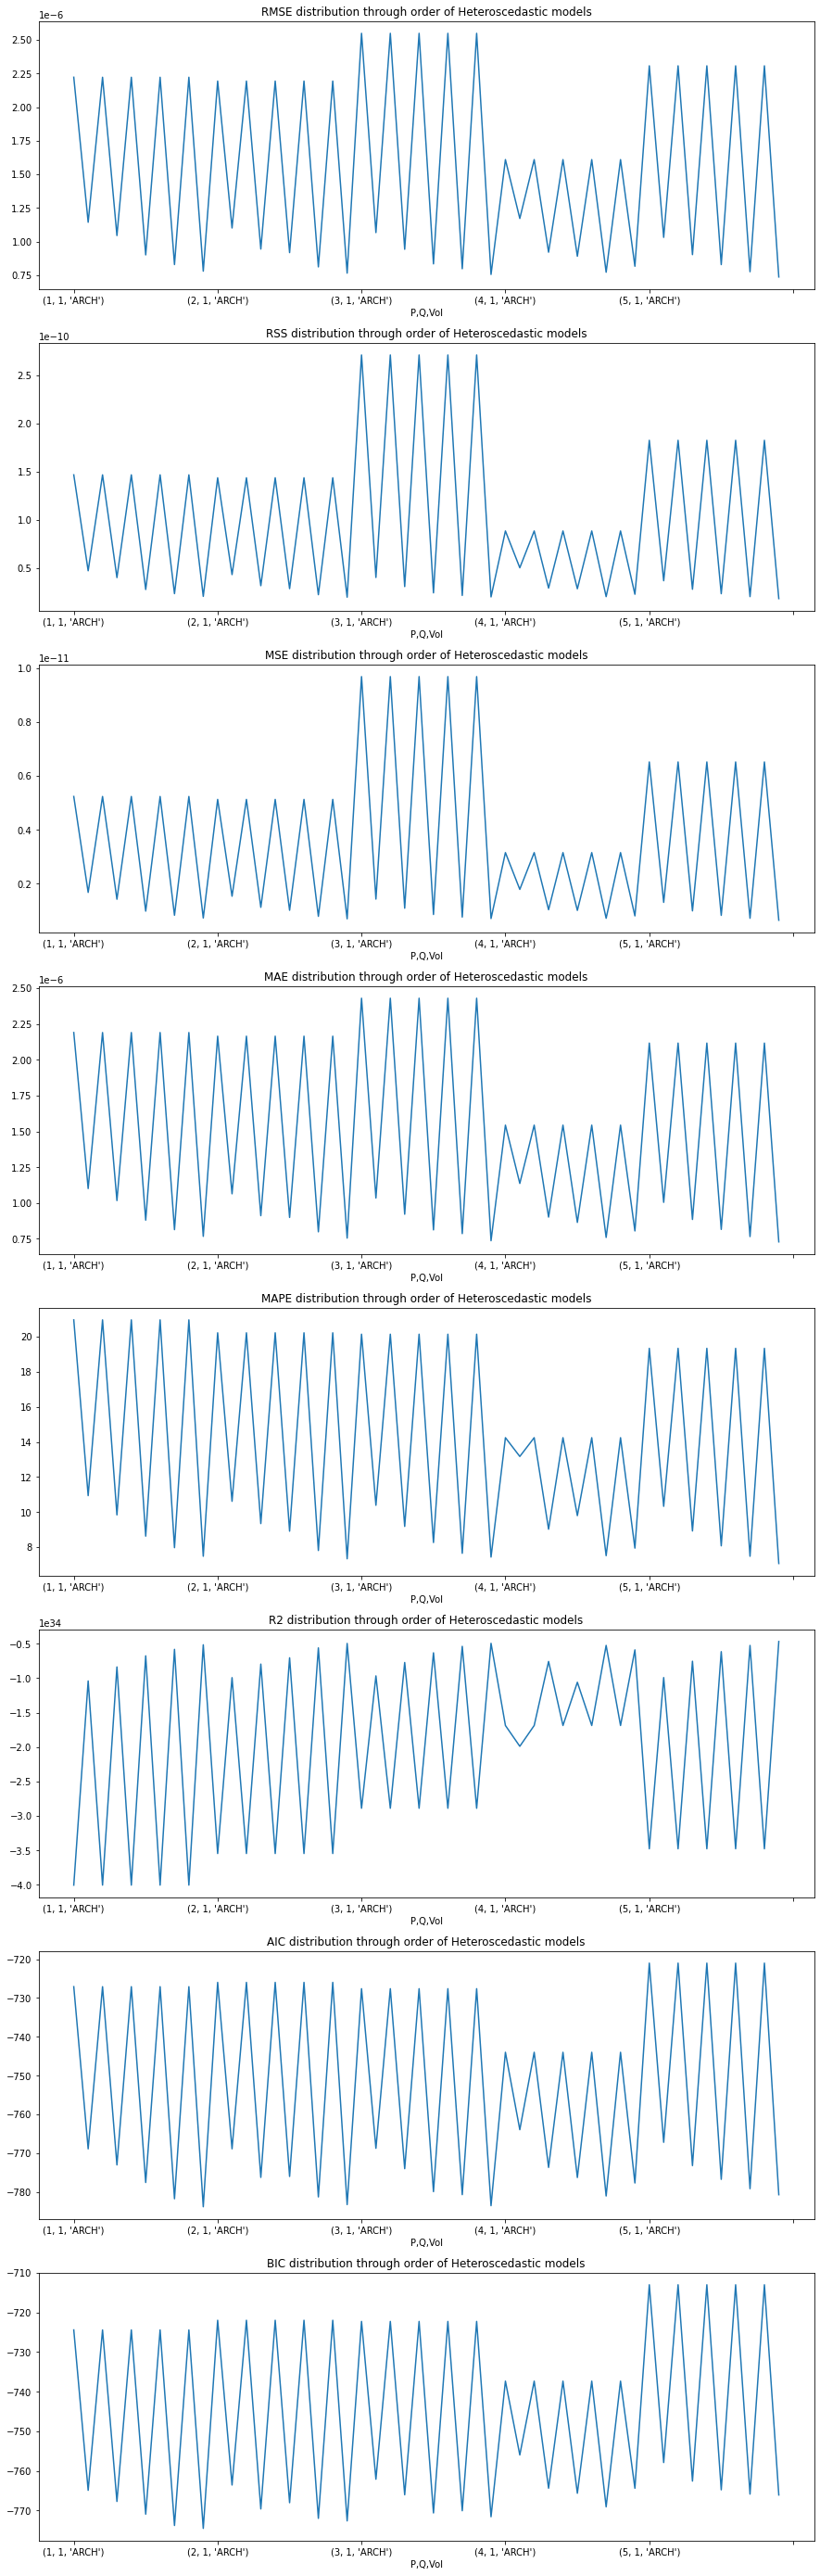

In [46]:
fig, axs = plt.subplots(nrows=all_metrics_df_test_arch_models.shape[1], ncols=1, figsize=(15, 50))

for idx, metric_title in enumerate(all_metrics_df_test_arch_models.columns):
    all_metrics_df_test_arch_models.reset_index().groupby(['P', 'Q', 'Vol'])[metric_title].mean().plot(
        title='{} distribution through order of Heteroscedastic models'.format(metric_title), ax=axs[idx]);

## Метрики у вигляді таблиць

In [48]:
all_metrics_df_test_arch_models.shape

(250, 8)

In [49]:
all_metrics_df_test_arch_models.head(3)

RMSE           RSS           MSE       MAE       MAPE  \
P Q Vol    Fold                                                              
1 1 'ARCH' 0     0.000003  2.000923e-10  7.146153e-12  0.000003  60.834581   
           1     0.000002  1.150999e-10  4.110712e-12  0.000002   3.860728   
           2     0.000003  2.057653e-10  7.348761e-12  0.000003  12.260109   

                           R2         AIC         BIC  
P Q Vol    Fold                                        
1 1 'ARCH' 0    -1.631893e+35 -714.604514 -711.940105  
           1     0.000000e+00 -730.087893 -727.423484  
           2    -2.622126e+33 -713.821703 -711.157294

#### усереднюємо метрики по фолдам для кожного набору порядків моделі

In [51]:
all_metrics_df_test_arch_models_resampled = all_metrics_df_test_arch_models.reset_index().groupby(
    ['P', 'Q', 'Vol']).mean()

In [52]:
all_metrics_df_test_arch_models_resampled

RMSE           RSS           MSE           MAE  \
P Q Vol                                                               
1 1 'ARCH'   2.222123e-06  1.466169e-10  5.236318e-12  2.190531e-06   
    'GARCH'  1.143724e-06  4.708547e-11  1.681624e-12  1.100766e-06   
  2 'ARCH'   2.222123e-06  1.466169e-10  5.236318e-12  2.190531e-06   
    'GARCH'  1.045108e-06  3.999713e-11  1.428469e-12  1.016820e-06   
  3 'ARCH'   2.222123e-06  1.466169e-10  5.236318e-12  2.190531e-06   
    'GARCH'  9.011967e-07  2.765026e-11  9.875094e-13  8.800177e-07   
  4 'ARCH'   2.222123e-06  1.466169e-10  5.236318e-12  2.190531e-06   
    'GARCH'  8.292551e-07  2.335610e-11  8.341464e-13  8.135702e-07   
  5 'ARCH'   2.222123e-06  1.466169e-10  5.236318e-12  2.190531e-06   
    'GARCH'  7.802385e-07  2.051064e-11  7.325229e-13  7.668148e-07   
2 1 'ARCH'   2.193829e-06  1.435754e-10  5.127691e-12  2.165095e-06   
    'GARCH'  1.101115e-06  4.310900e-11  1.539607e-12  1.064023e-06   
  2 'ARCH'   2.193829e-06  1.435754e-10  5.127691e-12  2.165095e-06   
    'GARCH'  9.445243e-07  3.159032e-11  1.128226e-12  9.111291e-07   
  3 'ARCH'   2.193829e-06  1.435754e-10  5.127691e-12  2.165095e-06   
    'GARCH'  9.180299e-07  2.855237e-11  1.019727e-12  8.988390e-07   
  4 'ARCH'   2.193829e-06  1.435754e-10  5.127691e-12  2.165095e-06   
    'GARCH'  8.119506e-07  2.226626e-11  7.952235e-13  7.986412e-07   
  5 'ARCH'   2.193829e-06  1.435754e-10  5.127691e-12  2.165095e-06   
    'GARCH'  7.654740e-07  1.966068e-11  7.021672e-13  7.545138e-07   
3 1 'ARCH'   2.548642e-06  2.709788e-10  9.677815e-12  2.430145e-06   
    'GARCH'  1.066991e-06  4.013615e-11  1.433434e-12  1.034645e-06   
  2 'ARCH'   2.548642e-06  2.709788e-10  9.677815e-12  2.430145e-06   
    'GARCH'  9.429430e-07  3.067175e-11  1.095420e-12  9.213355e-07   
  3 'ARCH'   2.548642e-06  2.709788e-10  9.677815e-12  2.430145e-06   
    'GARCH'  8.343480e-07  2.416804e-11  8.631443e-13  8.119250e-07   
  4 'ARCH'   2.548642e-06  2.709788e-10  9.677815e-12  2.430145e-06   
    'GARCH'  7.981572e-07  2.149024e-11  7.675087e-13  7.859477e-07   
  5 'ARCH'   2.548642e-06  2.709788e-10  9.677815e-12  2.430145e-06   
    'GARCH'  7.558479e-07  1.996602e-11  7.130722e-13  7.363749e-07   
4 1 'ARCH'   1.609813e-06  8.838469e-11  3.156596e-12  1.543729e-06   
    'GARCH'  1.171976e-06  5.020221e-11  1.792936e-12  1.136388e-06   
  2 'ARCH'   1.609813e-06  8.838469e-11  3.156596e-12  1.543729e-06   
    'GARCH'  9.211479e-07  2.913546e-11  1.040552e-12  9.013443e-07   
  3 'ARCH'   1.609813e-06  8.838469e-11  3.156596e-12  1.543729e-06   
    'GARCH'  8.910923e-07  2.843102e-11  1.015394e-12  8.641780e-07   
  4 'ARCH'   1.609813e-06  8.838469e-11  3.156596e-12  1.543729e-06   
    'GARCH'  7.723149e-07  2.024379e-11  7.229926e-13  7.592222e-07   
  5 'ARCH'   1.609813e-06  8.838469e-11  3.156596e-12  1.543729e-06   
    'GARCH'  8.166075e-07  2.272611e-11  8.116467e-13  8.046532e-07   
5 1 'ARCH'   2.307001e-06  1.824350e-10  6.515536e-12  2.116839e-06   
    'GARCH'  1.031406e-06  3.673844e-11  1.312087e-12  1.004317e-06   
  2 'ARCH'   2.307001e-06  1.824350e-10  6.515536e-12  2.116839e-06   
    'GARCH'  9.030620e-07  2.789723e-11  9.963298e-13  8.847669e-07   
  3 'ARCH'   2.307001e-06  1.824350e-10  6.515536e-12  2.116839e-06   
    'GARCH'  8.289937e-07  2.327810e-11  8.313606e-13  8.152986e-07   
  4 'ARCH'   2.307001e-06  1.824350e-10  6.515536e-12  2.116839e-06   
    'GARCH'  7.759964e-07  2.026330e-11  7.236894e-13  7.652472e-07   
  5 'ARCH'   2.307001e-06  1.824350e-10  6.515536e-12  2.116839e-06   
    'GARCH'  7.370280e-07  1.820545e-11  6.501945e-13  7.282751e-07   

                  MAPE            R2         AIC         BIC  
P Q Vol                                                       
1 1 'ARCH'   20.964321 -4.004868e+34 -727.067977 -724.403568  
    'GARCH'  10.934508 -1.039501e+34 -768.894205 -764.897591  
  2 'ARCH'   20.964321 -4.004868e+34 -727.067977 -724.403568  
    'GARCH'  